# Data Quality Test

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy.stats import linregress
from multiprocessing import Pool

import snpy
from snpy.CSPtemp import st_template

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "GFS Artemisia"
plt.rcParams['mathtext.fontset'] = "cm"

print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
DATA_DIR = 'csp_data'
PROCESSES = 8

SNooPy version: v2.6.0


In [3]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    delta_bins, std_bins, err_bins: arrays
        Arrays of
    """
    
    digitized = np.digitize(x_values, bins)
    delta_bins, std_bins, err_bins = [], [], []
    
    for i in range(0, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            wmean = np.nanmean(y)
            werr = np.sqrt(np.nan)
            wstd = np.nanstd(y)
            
            delta_bins.append(wmean)
            std_bins.append(wstd)
            err_bins.append(werr)
        else:
            delta_bins.append(np.nan)
            std_bins.append(np.nan)
            err_bins.append(np.nan)

    delta_bins = np.array(delta_bins) 
    std_bins = np.array(std_bins)
    err_bins = np.array(err_bins)
    
    return delta_bins, std_bins, err_bins

def extract_gradient(st=1.0, bands=None):
    """Extracts the gradient from the SNooPy templates.
    
    Parameters
    ----------
    st: float
        SN stretch.
    bands: list-like, default `None`
        Bands to fit.
        
    returns
    -------
    lc_dict: dictionary
        Dictionary with the template light curves and 
        gradients.
    """
    
    t = st_template()
    t.st = st
    epochs = np.arange(-10, 80)
    if bands is None:
        bands = ['g', 'r', 'i', 'u', 'B', 'V', 
                 'J', 'H', 'Y']
    lc_dict = {band:None for band in bands}

    for band in bands:
        mag, mag_err, mask = t.eval(band, epochs, gen=2)
        lc_dict[band] = {'mag':mag[mask], 
                         'mag_err':mag_err[mask],
                         'time':epochs[mask]}
        gradient = []
        for i in range(len(epochs[mask])-1):
            # slope, intercept, r_value, p_value, std_err
            slope, _, _, _, _ = linregress(epochs[mask][i:i+2], 
                                           mag[mask][i:i+2])
            gradient.append(slope)
        lc_dict[band].update({'slope':np.array(gradient)})
        
    return lc_dict

def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

In [4]:
def running_cadence_mask(step, phases):
    """Extracts a mask of the given phases
    with True every `step` amount of items. The 'running'
    part means that the first observations moves along
    the time axes.
    
    Parameters
    ----------
    step: int
        Step to use to take every x amount of items.
    phases: list-like
        Phases.
        
    Returns
    -------
    running_masks: bool list
        List of masks.
    """
    length = len(phases)
    indeces = list(range(length))
    
    running_masks = []
    for i, phase in enumerate(phases):
        mask = []
        step_indeces = indeces[i::step]

        for index in indeces:
            if index in step_indeces:
                mask.append(True)
            else:
                mask.append(False)
        mask = np.array(mask)       
        running_masks.append(mask)
        if phase > 0 or len(step_indeces)<=3:
            break
    return running_masks

def update_running_cadence(sn_file, steps, bands=None):
    """Updates the light-curves cadence with the 
    given steps and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    steps: list-like
        Steps to use to take every x amount of items.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    cadence_df: DataFrame
        Pandas dataframe with cadences and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = sn.allbands()
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy = deepcopy(sn)
    sn_copy.fit(bands)
    
    cadences_list = []
    cadences = {band:None for band in sn_copy.allbands()}
    for band in sn_copy.allbands():
        lc_times = sn_copy.data[band].MJD
        cadences[band] = np.mean(np.diff(lc_times))
        
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    first_phase = sn_copy.data[bands[0]].get_t()[0]/(1+sn_copy.z)
    
    cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err, 
                     'first_phase':first_phase, 
                    'name':sn_copy.name, 'step':0})
    cadences_list.append(cadences)

    phases_dict = {band:sn_copy.data[band].get_t()/(1+sn_copy.z) 
                                               for band in bands}
    # fits for multiple cadences
    for step in steps:
        mask_dict = {band:None for band in bands}
        for band in bands:
            phases = phases_dict[band]
            running_masks = running_cadence_mask(step, phases)
            mask_dict[band] = running_masks
           
        # check max length
        max_len = 50
        for mask_list in mask_dict.values():
            if len(mask_list)<max_len:
                max_len = len(mask_list)
            
        # iterate over each running 1st observation
        for i in range(max_len):
            cadences = {band:None for band in bands}
            sn_copy = deepcopy(sn)
            
            for band in bands:
                mask = mask_dict[band][i]
                
                sn_copy.data[band].mag = sn_copy.data[band].mag[mask]
                sn_copy.data[band].magnitude = sn_copy.data[band].magnitude[mask]
                sn_copy.data[band].e_mag = sn_copy.data[band].e_mag[mask]
                sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
                
                lc_times = sn_copy.data[band].MJD
                cadences[band] = np.mean(np.diff(lc_times))
                
                sn_copy.data[band].__dict__['mask'] = [True]*len(lc_times)
                sn_copy.data[band].sids = np.zeros_like(lc_times)
                
            try:
                sn_copy.fit(bands)

                Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                           include_sys=False)
                st, st_err = get_parameter(sn_copy, 'st', 
                                            include_sys=False)
                first_phase = sn_copy.data[bands[0]].get_t()[0]/(1+sn_copy.z)

                cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                                 'st':st, 'st_err':st_err, 
                                 'first_phase':first_phase, 
                                'name':sn_copy.name, 'step':step})
                cadences_list.append(cadences)
            except Exception as message:
                print(f'Iteration numer {i} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for cadence in cadences_list:
        for band in bands:
            if band not in cadence.keys():
                cadence.update({band:np.nan})
      
    cadence_df = pd.DataFrame(cadences_list)
    
    return cadence_df

def update_snr(sn_file, multi, bands=None):
    """Updates the light-curves S/N with the 
    given multiplicative values and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    multi: list-like
        Multiplicative values such that x*sigma is used
        as errors in the observations.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    snr_df: DataFrame
        Pandas dataframe with snr and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = sn.allbands()
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy = deepcopy(sn)
    sn_copy.fit(bands)
    
    snr_list = []
    snr_dict = {band:None for band in sn_copy.allbands()}
    for band in sn_copy.allbands():
        snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                    'name':sn_copy.name})
    snr_list.append(snr_dict)

    # iterate over S/N multipliers
    for mult in multi:
        snr_dict = {band:None for band in bands}
        sn_copy = deepcopy(sn)
        for band in bands:   
            # update flux errors
            sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux
            sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux

            zp = sn_copy.data[band].mag + 2.5*np.log10(sn_copy.data[band].flux)
            # randomise observations within uncertainties
            new_flux = np.random.normal(sn_copy.data[band].flux, 
                                        sn_copy.data[band].e_flux)
            sn_copy.data[band].flux = new_flux

            # update magnitudes and mag errors
            new_mag = -2.5*np.log10(new_flux) + zp
            new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
            sn_copy.data[band].mag = new_mag
            sn_copy.data[band].magnitude = new_mag
            sn_copy.data[band].e_mag = new_mag_err
            
            snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
            # use median as S/N can vary a lot within a light curve
            snr_dict[band] = np.median(snr)

        try:
            sn_copy.fit(bands)
            Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                       include_sys=False)
            st, st_err = get_parameter(sn_copy, 'st', 
                                        include_sys=False)
            snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                             'st':st, 'st_err':st_err, 
                            'name':sn_copy.name})
            snr_list.append(snr_dict)
        except Exception as message:
                print(f'Multiplier {mult} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for snr in snr_list:
        for band in bands:
            if band not in snr.keys():
                snr.update({band:np.nan})
      
    snr_df = pd.DataFrame(snr_list)
    
    return snr_df

In [5]:
def update_NIR_snr(sn_file, multi, bands=None):
    """Updates the NIR light-curves S/N with the 
    given multiplicative values and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    multi: list-like
        Multiplicative values such that x*sigma is used
        as errors in the observations.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    snr_df: DataFrame
        Pandas dataframe with NIR snr and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = ['g', 'r', 'J', 'H']
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy0 = deepcopy(sn)
    sn_copy0.fit(bands)
    
    snr_list = []
    snr_dict = {band:None for band in bands}
    for band in bands:
        snr = sn_copy0.data[band].flux/sn_copy0.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy0, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy0, 'st', 
                                include_sys=False)
    Jmax, Jmax_err = get_parameter(sn_copy0, 'Jmax', 
                                    include_sys=False)
    Hmax, Hmax_err = get_parameter(sn_copy0, 'Hmax', 
                                    include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                     'Jmax':Jmax, 'Jmax_err':Jmax_err,
                     'Hmax':Hmax, 'Hmax_err':Hmax_err,
                    'name':sn_copy0.name})
    snr_list.append(snr_dict)
    
    # 2nd fit
    sn_copy = deepcopy(sn)
    for band in ['J', 'H']:
        mult = 1
        # mask for single epoch closest to Tmax
        ind = np.argmin(np.abs(sn_copy.data[band].MJD-sn_copy0.Tmax))
        mask = sn_copy.data[band].MJD[ind]==sn_copy.data[band].MJD

        sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux[mask]
        sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux[mask]

        zp = sn_copy.data[band].mag[mask] + 2.5*np.log10(sn_copy.data[band].flux[mask])
        # randomise observations within uncertainties
        new_flux = np.random.normal(sn_copy.data[band].flux[mask], 
                                    sn_copy.data[band].e_flux)
        sn_copy.data[band].flux = new_flux

        # update magnitudes and mag errors
        new_mag = -2.5*np.log10(new_flux) + zp
        new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
        sn_copy.data[band].mag = new_mag
        sn_copy.data[band].magnitude = new_mag
        sn_copy.data[band].e_mag = new_mag_err

        sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
        sn_copy.data[band].__dict__['mask'] = [True]
        sn_copy.data[band].sids = [0]

    sn_copy.fit(bands)
    
    snr_dict = {band:None for band in bands}
    for band in bands:
        snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    Jmax, Jmax_err = get_parameter(sn_copy, 'Jmax', 
                                    include_sys=False)
    Hmax, Hmax_err = get_parameter(sn_copy, 'Hmax', 
                                    include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                     'Jmax':Jmax, 'Jmax_err':Jmax_err,
                     'Hmax':Hmax, 'Hmax_err':Hmax_err,
                    'name':sn_copy.name})
    snr_list.append(snr_dict)

    # iterate over S/N multipliers
    for mult in multi:
        snr_dict = {band:None for band in bands}
        sn_copy = deepcopy(sn)
        for band in ['J', 'H']:   
            # mask for single epoch closest to Tmax
            ind = np.argmin(np.abs(sn_copy.data[band].MJD-sn_copy0.Tmax))
            mask = sn_copy.data[band].MJD[ind]==sn_copy.data[band].MJD

            sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux[mask]
            sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux[mask]

            zp = sn_copy.data[band].mag[mask] + 2.5*np.log10(sn_copy.data[band].flux[mask])
            # randomise observations within uncertainties
            new_flux = np.random.normal(sn_copy.data[band].flux[mask], 
                                        sn_copy.data[band].e_flux)
            sn_copy.data[band].flux = new_flux

            # update magnitudes and mag errors
            new_mag = -2.5*np.log10(new_flux) + zp
            new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
            sn_copy.data[band].mag = new_mag
            sn_copy.data[band].magnitude = new_mag
            sn_copy.data[band].e_mag = new_mag_err

            sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
            sn_copy.data[band].__dict__['mask'] = [True]
            sn_copy.data[band].sids = [0]

        try:
            sn_copy.fit(bands)
            snr_dict = {band:None for band in bands}
            for band in bands:
                snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
                snr_dict[band] = np.mean(snr)
            Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                       include_sys=False)
            st, st_err = get_parameter(sn_copy, 'st', 
                                        include_sys=False)
            Jmax, Jmax_err = get_parameter(sn_copy, 'Jmax', 
                                        include_sys=False)
            Hmax, Hmax_err = get_parameter(sn_copy, 'Hmax', 
                                        include_sys=False)
            snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                             'st':st, 'st_err':st_err, 
                             'Jmax':Jmax, 'Jmax_err':Jmax_err,
                             'Hmax':Hmax, 'Hmax_err':Hmax_err,
                            'name':sn_copy.name})
            snr_list.append(snr_dict)
        except Exception as message:
                print(f'Multiplier {mult} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for snr in snr_list:
        for band in bands:
            if band not in snr.keys():
                snr.update({band:np.nan})
      
    snr_df = pd.DataFrame(snr_list)
    
    return snr_df

In [6]:
def pool_fit_cad(inputs):
    '''Fits a SN with SNooPy using multiple cadences and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_running_cadence()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, steps, bands = inputs
        cadence_df = update_running_cadence(sn_file, steps, bands)
        return cadence_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')
        
def pool_fit_snr(inputs):
    '''Fits a SN with SNooPy using multiple S/N and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_snr()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, multi, bands = inputs
        snr_df = update_snr(sn_file, multi, bands)
        return snr_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')
        
def pool_fit_NIR_snr(inputs):
    '''Fits a SN with SNooPy using multiple NIR S/N and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_NIR_snr()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, multi, bands = inputs
        snr_df = update_NIR_snr(sn_file, multi, bands)
        return snr_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')

In [68]:
# sn_file = 'csp_data/SN2004eo_snpy.txt'
# steps = [3]
# df = update_NIR_snr(sn_file, steps)

## Cadences

In [9]:
bands = ['g', 'r']
steps = range(2, 11)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

%time cadences_list = Pool(PROCESSES).map(pool_fit_cad, ([sn_file, steps, bands] for sn_file in sn_files))

Unable to fit csp_data/SN2006hx_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit csp_data/SN2005kc_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Error: covariance matrix has negative diagonal element.
       Error for Tmax not computed
Error: covariance matrix has negative diagonal element.
       Error for rmax not computed
Unable to fit csp_data/SN2006kf_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit csp_data/SN2005hc_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Warning!  less than 1 degree of freedom!
Error: covariance matrix has negative diagonal element.
       Error 

In [10]:
cad_stats_df = pd.concat(cadences_list, ignore_index=True)
cad_stats_df.to_csv('cadence_stats.csv', index=False)

___
### Cadence Analysis

In [181]:
cad_stats_df = pd.read_csv('cadence_stats.csv')
sn_names = cad_stats_df.name.unique()

# add redshift
z_list = []
sne = []
for sn_file in glob.glob('csp_data/*'):
     with open(sn_file, 'r') as data_file:
            sn_info = data_file.readline().split()  # header
            z = float(sn_info[1])
            z_list.append(z)
            
            sn_name = sn_file.split('/')[-1].split('_')[0]
            sne.append(sn_name)
            
z_array = np.array(z_list)
sne = np.array(sne)

df_z = []
for sn_name in cad_stats_df.name:
    z = z_array[sne==sn_name][0]
    df_z.append(z)
    
cad_stats_df['zspec'] = df_z
####

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[], 'first_phase':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}

for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    ref_df = sn_df[sn_df.step==0]
    
    sim_df = sn_df[1:]  # remove reference from this df
    sim_df = sim_df[sim_df.first_phase>=-15]
    sim_df = sim_df[sim_df.g.values/(1+sim_df.zspec.values)<=10]
    Tmax_diff = sim_df.Tmax.values - ref_df.Tmax.values[0]
    res_dict['Tmax_diff'] += list(Tmax_diff)
    res_dict['Tmax_err'] += list(sim_df.Tmax_err)
    res_dict['g'] += list(sim_df.g)
    res_dict['r'] += list(sim_df.r)
    res_dict['first_phase'] += list(sim_df.first_phase)
            
    lc_dict = extract_gradient(ref_df.st.values[0])
    for band in ['J', 'H']:
        lc = lc_dict[band]
        time = lc['time'][:-1]+0.5
        grad = lc['slope']
        for val in Tmax_diff:
            err = val * grad  # the offset we want per object
            lc_snake[band]['err'].append(err)
            lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)

In [13]:
step = 1
cadences = np.arange(1.5, 10.5+step, step)
for i in range(len(cadences)-1):
    cad_min = cadences[i]
    cad_max = cadences[i+1]
    mask = (cad_min<=res_df.g) & (res_df.g<=cad_max)
    cad_df = res_df[mask]

    label = f'{int(cad_min+step/2)} days'
    wmean = np.average(cad_df.Tmax_diff.values, 
                       weights=1/cad_df.Tmax_err.values**2)
    print(f'Mean delta Tmax for cadence={label}: {wmean}')

Mean delta Tmax for cadence=2 days: 0.018851333677487
Mean delta Tmax for cadence=3 days: -0.001907994882506799
Mean delta Tmax for cadence=4 days: 0.010288056930053408
Mean delta Tmax for cadence=5 days: 0.0549877765966003
Mean delta Tmax for cadence=6 days: 0.004120594683507299
Mean delta Tmax for cadence=7 days: 0.00041129604651242717
Mean delta Tmax for cadence=8 days: -0.019204200508778597
Mean delta Tmax for cadence=9 days: 0.014992257932426957
Mean delta Tmax for cadence=10 days: 0.0002485734526077743


In [19]:
import seaborn as sns
COLOUR_PALETTE = sns.color_palette('tab10')[1:] + sns.color_palette('tab10')[1:]

Mean delta Tmax for cadence=2 days: 0.0032770935783560965
Mean delta Tmax for cadence=3 days: -0.001348409220190163
Mean delta Tmax for cadence=4 days: 0.008707224517472115
Mean delta Tmax for cadence=5 days: 0.047949822491047546


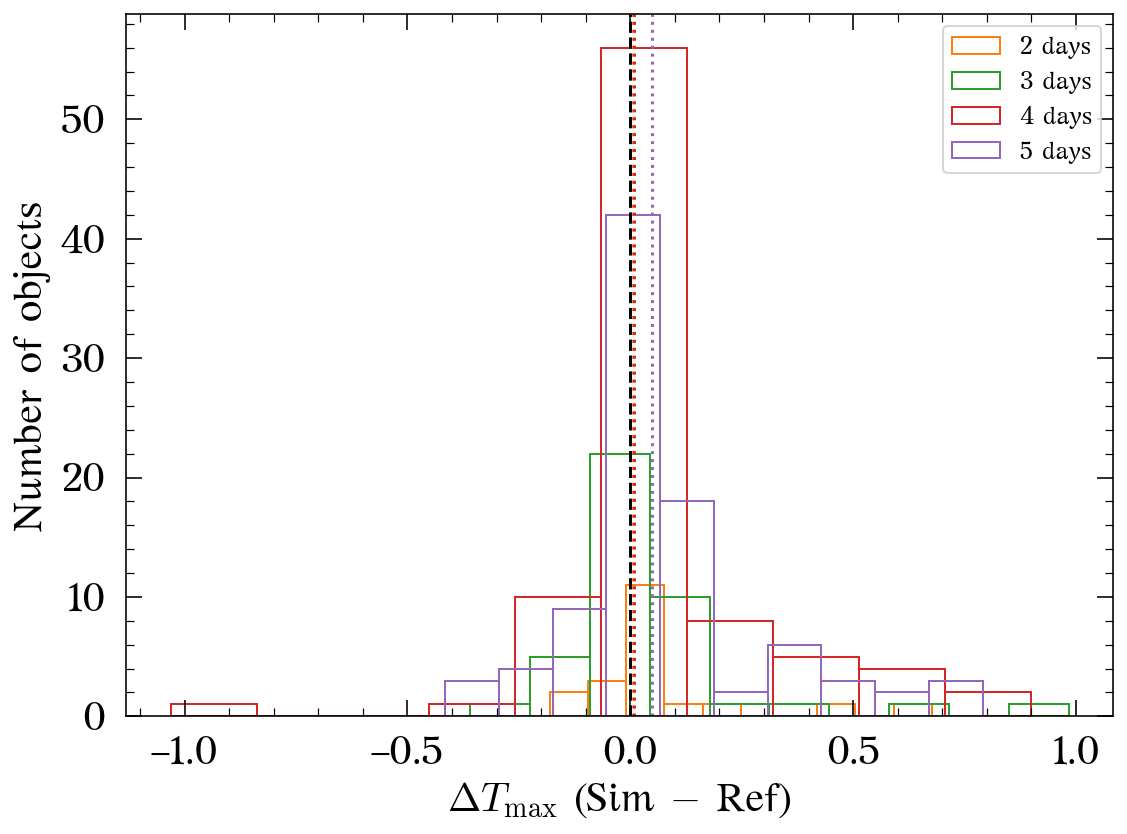

Average delta Tmax: 0.006913781838922793


In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

#bins = np.arange(-2, 2, 0.1)
step = 1
cadences = np.arange(1.5, 5.5+step, step)
for i in range(len(cadences)-1):
    cad_min = cadences[i]
    cad_max = cadences[i+1]
    mask = (cad_min<=res_df.g) & (res_df.g<=cad_max)
    cad_df = res_df[mask]

    colour = COLOUR_PALETTE[i]
    label = f'{int(cad_min+step/2)} days'
    ax.hist(cad_df.Tmax_diff, fc=(0, 0, 0, 0.0), edgecolor=colour, label=label)
    
    wmean = np.average(cad_df.Tmax_diff.values, 
                       weights=1/cad_df.Tmax_err.values**2)
    ax.axvline(wmean, ls='dotted', c=colour)
    print(f'Mean delta Tmax for cadence={label}: {wmean}')
    
ax.axvline(0, ls='--', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(-2, 2)
ax.legend()

fig.tight_layout()
plt.show()

mask = ~np.isnan(res_df.Tmax_err.values)
mask = res_df.Tmax_err.values>0.0
wmean = np.average(res_df.Tmax_diff.values[mask], 
                       weights=1/res_df.Tmax_err.values[mask]**2)
print(f'Average delta Tmax: {wmean}')

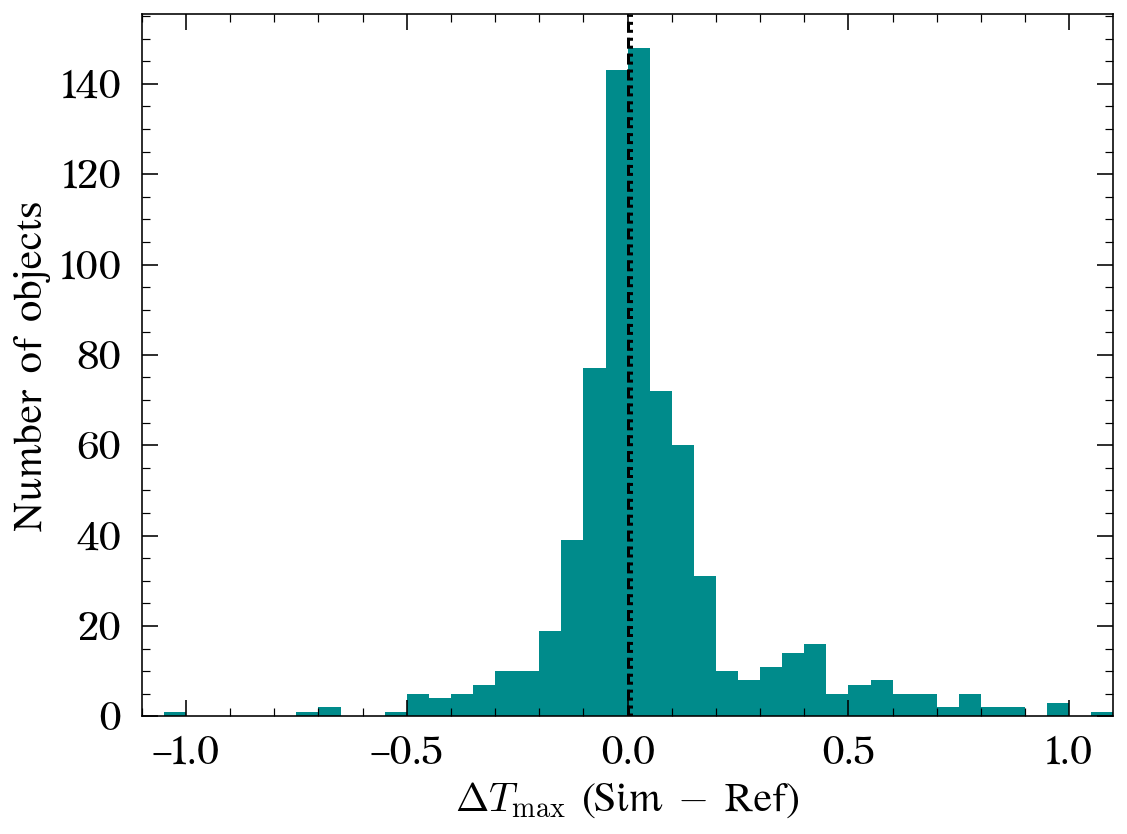

0.008176660375119453 0.514890961199027


In [182]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-1.1, 1.15, 0.05)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
wmean = np.average(res_df.Tmax_diff.values,
                  weights=1/res_df.Tmax_err.values**2)
ax.axvline(wmean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-1.1, 1.1)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_cadence.pdf')
plt.show()

print(wmean, res_df.Tmax_diff.std())

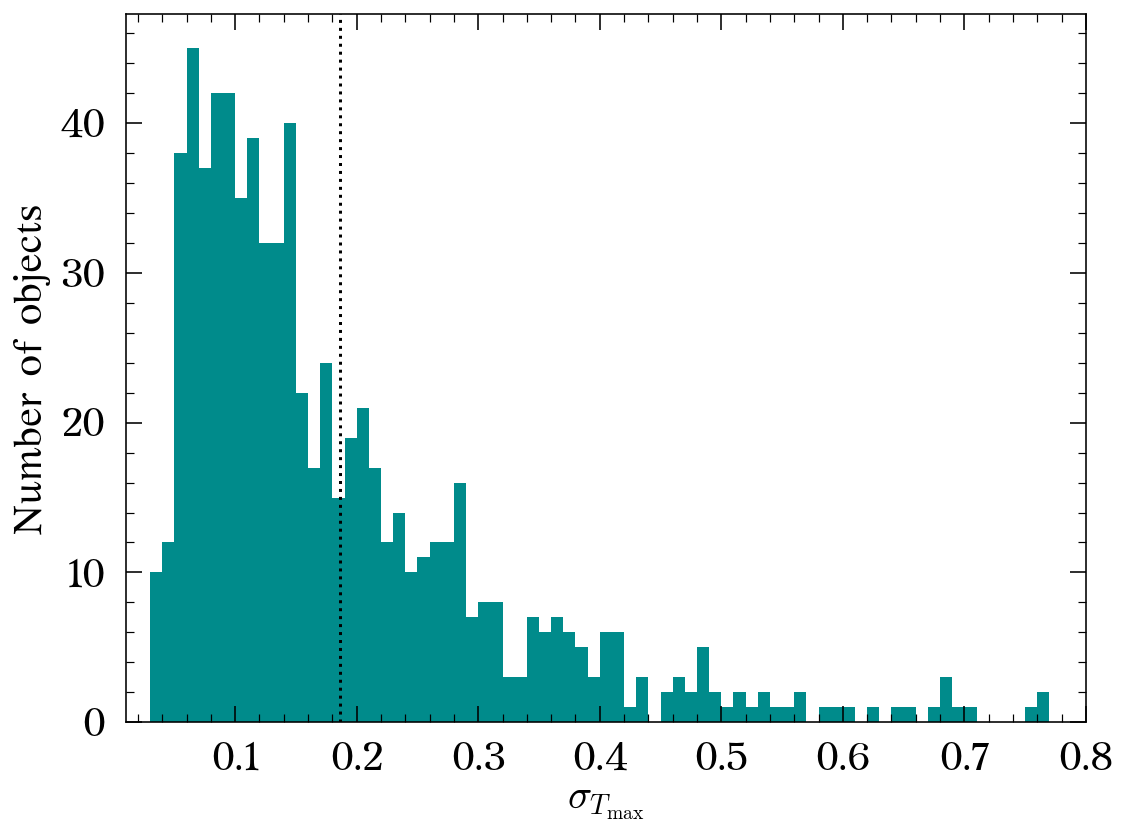

0.186121638918111


In [183]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.9, 0.01)
ax.hist(res_df.Tmax_err, bins, color='darkcyan')
ax.axvline(res_df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.01, 0.8)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_cadence.pdf')
plt.show()
print(res_df.Tmax_err.mean())

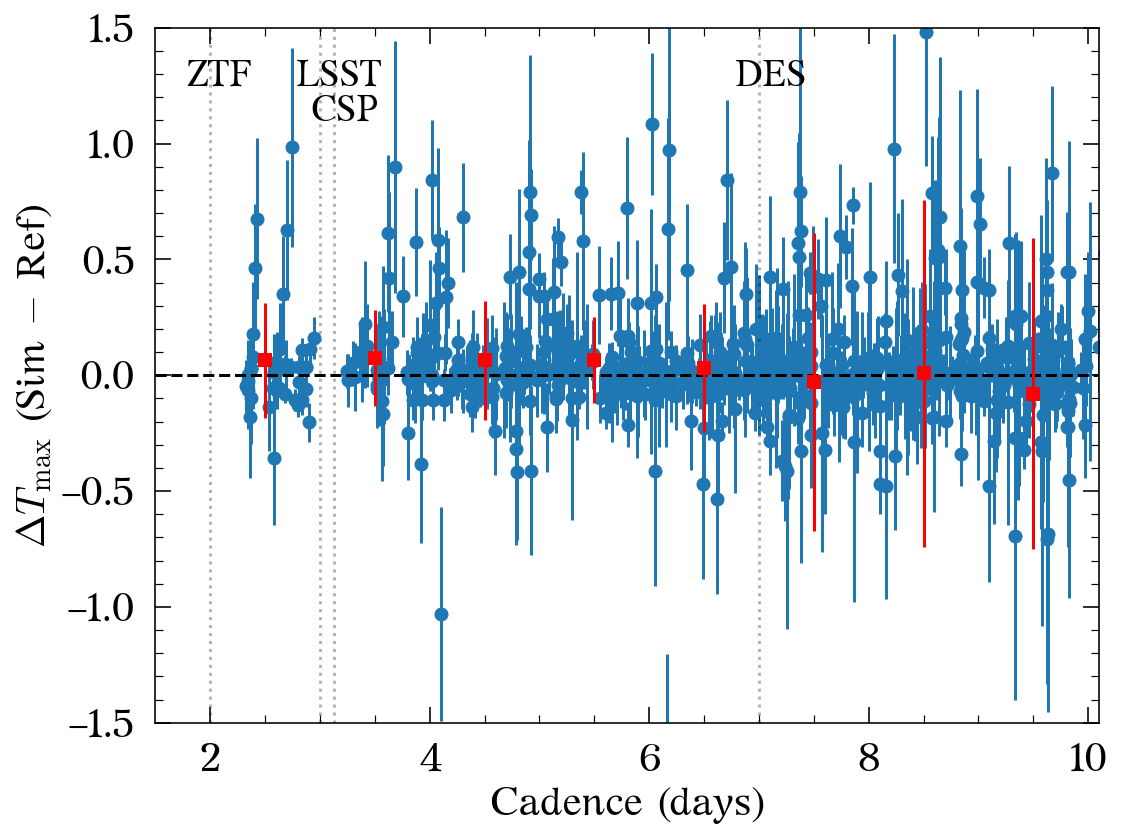

3.1314074109217844


In [189]:
# average CSP cadence
avg_cad = []
for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    sn_df = sn_df[sn_df.step==0]
    cad = sn_df.g.values[0]
    avg_cad.append(cad)
    
avg_cad = np.array(avg_cad).mean()

cadence_dict = {'CSP':avg_cad,
                'ZTF':2,
                'DES':7, 
                'LSST':3}
text_shift = []

bins = np.arange(0, 11, 1)
bins_results =  bin_values(bins, res_df.g.values/(1+sn_df.zspec.values), 
                           res_df.Tmax_diff.values, 
                           np.ones_like(res_df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

#ax.scatter(res_df.g, res_df.Tmax_diff, marker='o' , ec='k', facecolors='none')
ax.errorbar(res_df.g/(1+sn_df.zspec.values), res_df.Tmax_diff, yerr=res_df.Tmax_err, fmt='o')

# bins
ax.errorbar(bins-0.5, delta_bins, yerr=std_bins, fmt='s', c='red', zorder=10)

ax.axhline(0, ls='--', c='k', zorder=5)

for survey, cad in cadence_dict.items():
    if survey in ['ZTF', 'LSST', 'DES']:
        yoffset = 1.25
    else:
        yoffset = 1.1
    ax.axvline(cad, ls='dotted', c='k', alpha=0.3)
    ax.text(cad-0.22, yoffset, survey, fontsize=18)

ax.set_xlabel(r'Cadence (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(1.5, 10.1)
ax.set_ylim(-1.5, 1.5)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_cadence.pdf')
plt.show()

print(avg_cad)

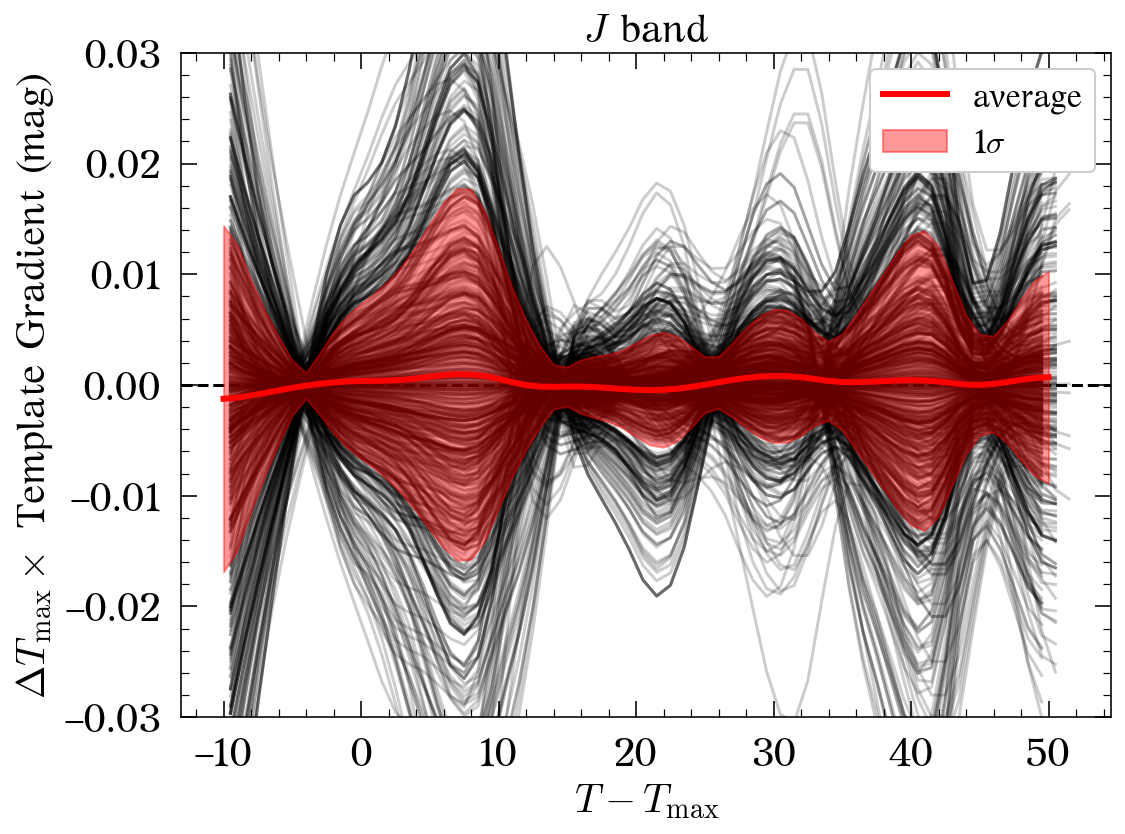

In [17]:
band = 'J'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.05):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3, zorder=30)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, 
                color='r', alpha=0.4, label='1$\sigma$', zorder=20)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max} \times$ Template Gradient (mag)', fontsize=20)
ax.set_title(f'${band}$ band', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.03, 0.03)
ax.legend(loc=1, fontsize=16, framealpha=1).set_zorder(10)
fig.tight_layout()
#plt.savefig(f'paper_plots/Tmax_gradient_cadence_{band}.pdf')
plt.show()

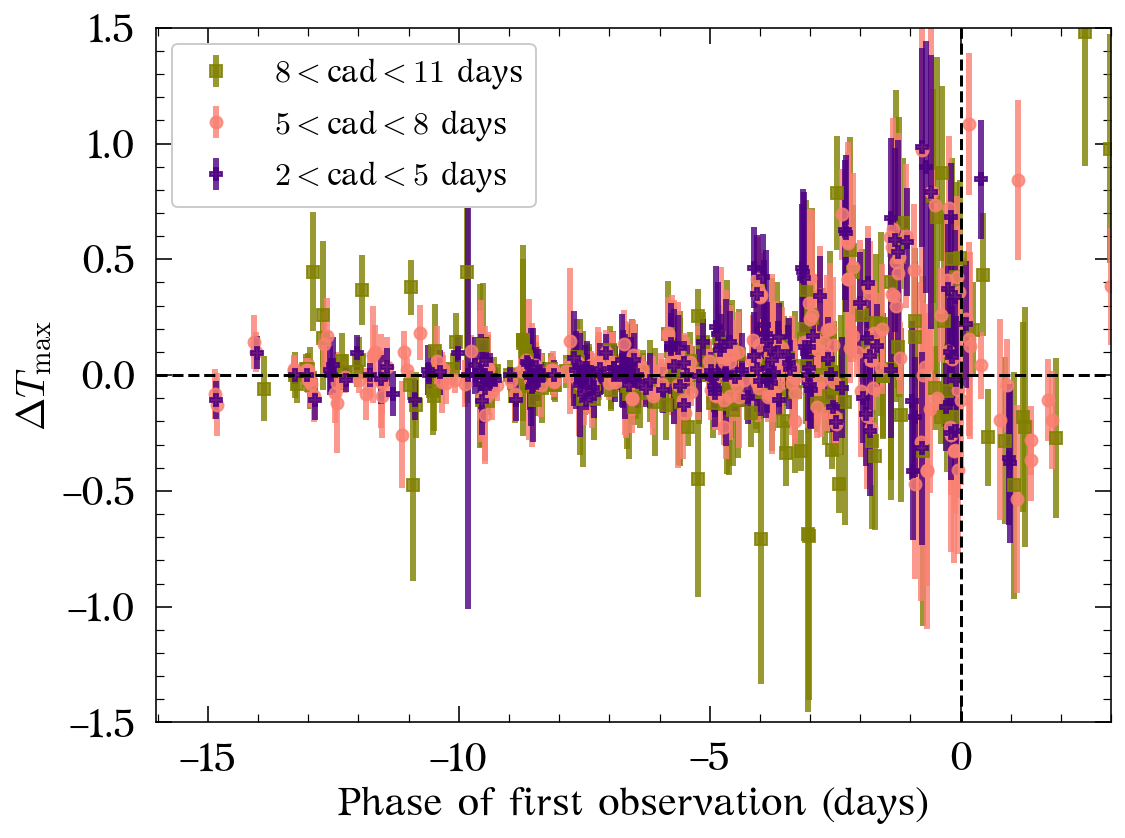

In [55]:
cadences = np.arange(2, 12, 3)[::-1]
colours = ['olive', 'salmon', 'indigo']
markers = ['s', 'o', 'P']

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(cadences)-1):
    mask = (res_df.g>cadences[i+1]) & (res_df.g<cadences[i])
    cad_df = res_df[mask]
    x = cad_df.first_phase.values
    y = cad_df.Tmax_diff.values
    yerr = cad_df.Tmax_err.values

    label = f'${cadences[i+1]}<$cad$<{cadences[i]}$ days'
    colour = colours[i]
    marker = markers[i]
    ax.errorbar(x, y, yerr=yerr, fmt=marker, lw=3, 
                label=label, alpha=0.8, c=colour)
    
ax.axhline(0, ls='--', c='k', zorder=10)
ax.axvline(0, ls='--', c='k', zorder=10)

ax.set_xlabel(r'Phase of first observation (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(None, 3)
ax.legend(loc=2, fontsize=16, framealpha=1).set_zorder(20)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_running_cadence.pdf')
plt.show()

___
## Signal-to-Noise

In [219]:
bands = ['g', 'r']
multi = range(2, 7)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

snr_list = Pool(PROCESSES).map(pool_fit_snr, ([sn_file, multi, bands] for sn_file in sn_files))

/tmp/ipykernel_1366/1412621745.py:211: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/tmp/ipykernel_1366/1412621745.py:211: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/sn.py:360: RuntimeWarning: invalid value encountered in log10
  temp1[i] = -2.5*log10(af) + self.data[band].filter.zp


In [220]:
snr_stats_df = pd.concat(snr_list, ignore_index=True)
snr_stats_df.to_csv('snr_stats.csv', index=False)

___
### Signal-to-Noise Analysis

In [18]:
snr_stats_df = pd.read_csv('snr_stats.csv')
sn_names = snr_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}

for sn_name in sn_names:
    sn_df = snr_stats_df[snr_stats_df.name==sn_name]
    ref_df = sn_df[sn_df.B>0]
        
    sim_df = sn_df[1:]  # remove reference from this df
    sim_df = sim_df[sim_df.g<=500]
    Tmax_diff = sim_df.Tmax.values - ref_df.Tmax.values[0]
    res_dict['Tmax_diff'] += list(Tmax_diff)
    res_dict['Tmax_err'] += list(sim_df.Tmax_err)
    res_dict['g'] += list(sim_df.g)
    res_dict['r'] += list(sim_df.r)
            
    lc_dict = extract_gradient(ref_df.st.values[0])
    for band in ['J', 'H']:
        lc = lc_dict[band]
        time = lc['time'][:-1]+0.5
        grad = lc['slope']
        for val in Tmax_diff:
            err = val * grad  # the offset we want per object
            lc_snake[band]['err'].append(err)
            lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)
# weird outliers, but just very few simulations
res_df = res_df[res_df.Tmax_diff>-2]  # huge Tmax diff
res_df = res_df[res_df.Tmax_err>0.001]  # I don't trust these small uncertainties 

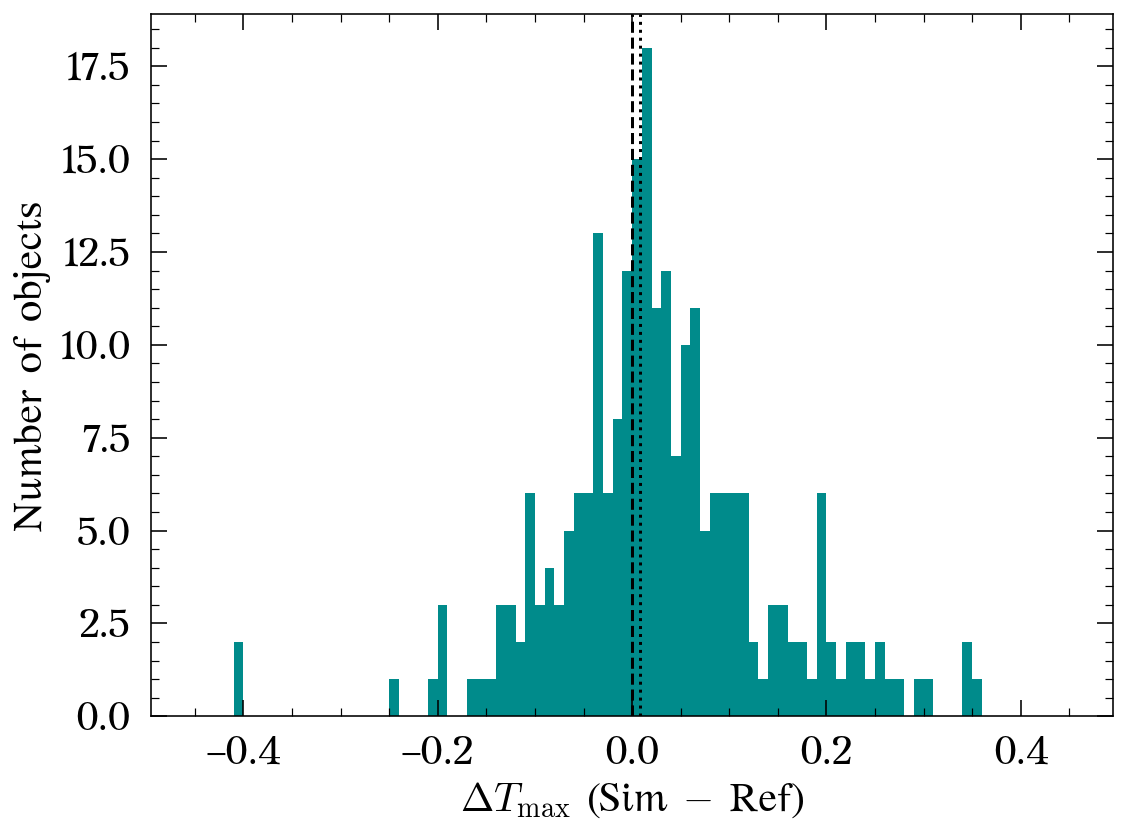

0.007753356126655153


In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.45, 0.46, 0.01)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
wmean = np.average(res_df.Tmax_diff.values, 
                   weights=1/res_df.Tmax_err.values**2)
ax.axvline(wmean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(-0.9, 0.9)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_snr.pdf')
plt.show()

print(wmean)

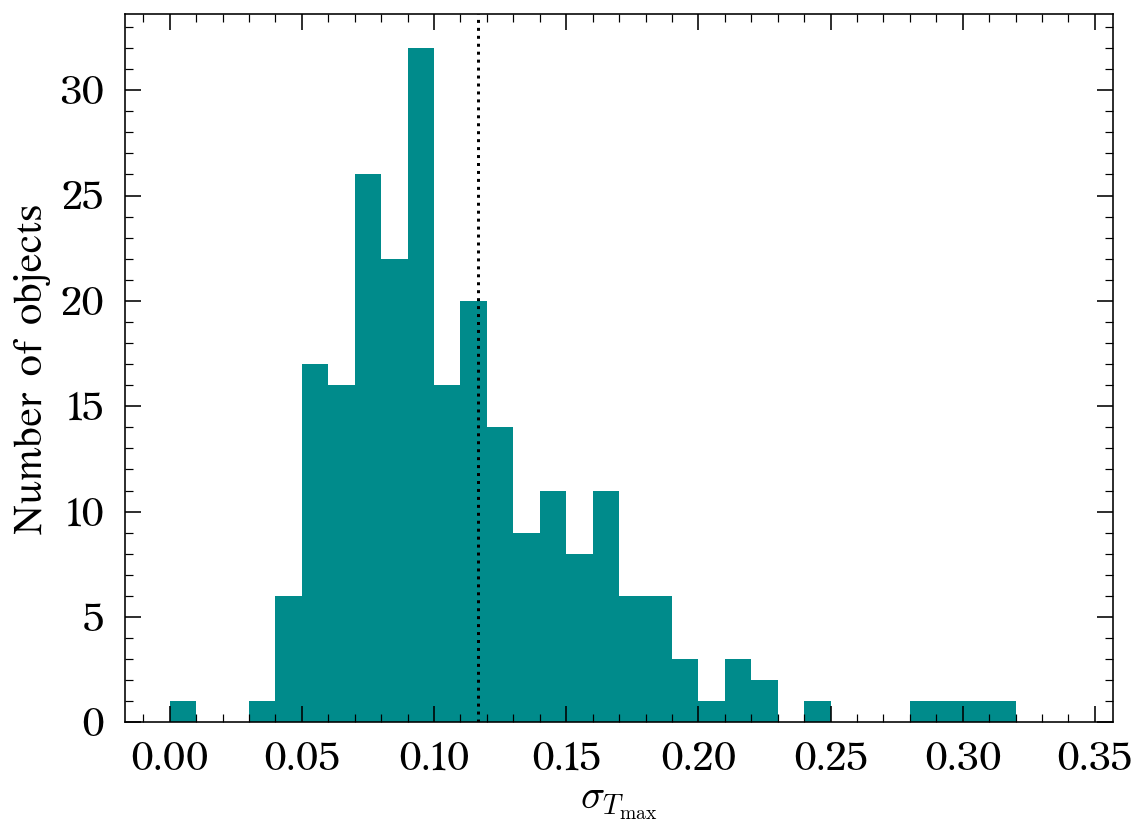

0.11652963273202993


In [20]:
# remove large uncertainty that can shift the mean
df = res_df[res_df.Tmax_err < 0.5]  

fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.35, 0.01)
ax.hist(df.Tmax_err, bins, color='darkcyan')
ax.axvline(df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(0, 0.55)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_snr.pdf')
plt.show()

print(df.Tmax_err.mean())

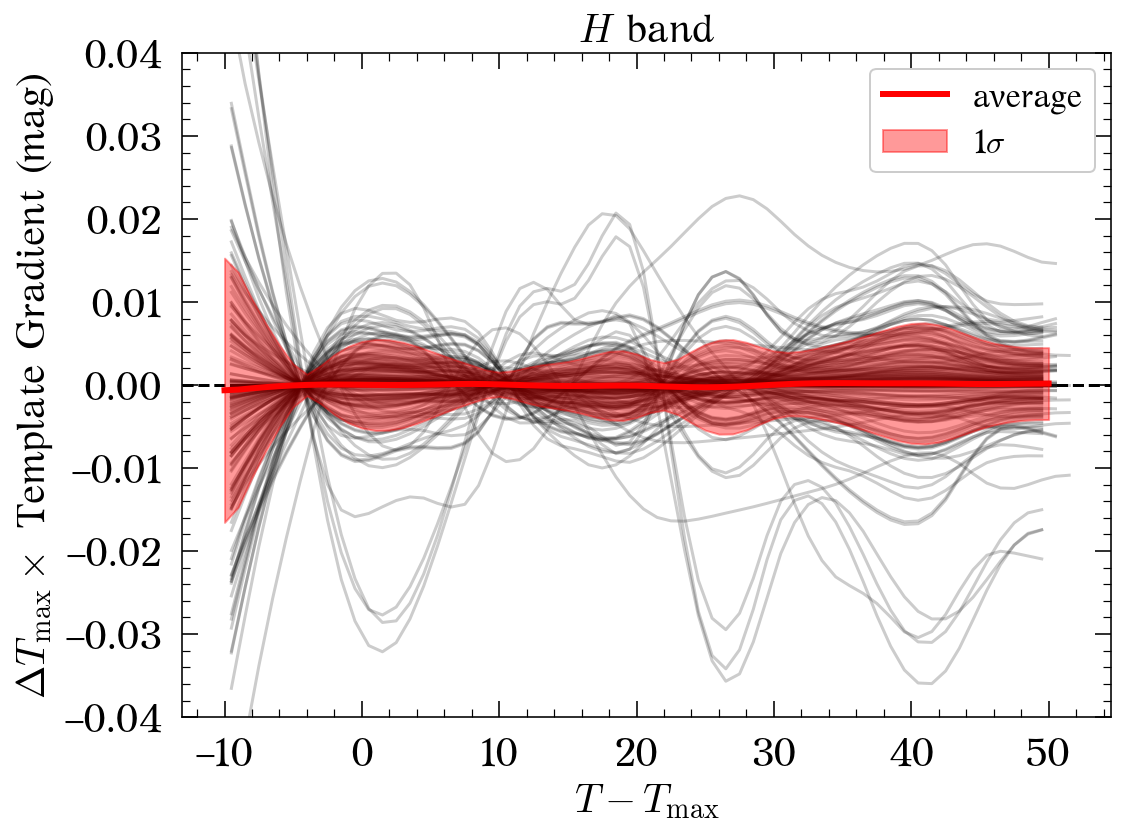

In [301]:
band = 'H'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.1):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3, zorder=30)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, 
                color='r', alpha=0.4, zorder=20, label='1$\sigma$')
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max} \times$ Template Gradient (mag)', fontsize=20)
ax.set_title(f'${band}$ band', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.04, 0.04)
ax.legend(loc=1, fontsize=16, framealpha=1).set_zorder(20)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_snr_{band}.pdf')
plt.show()

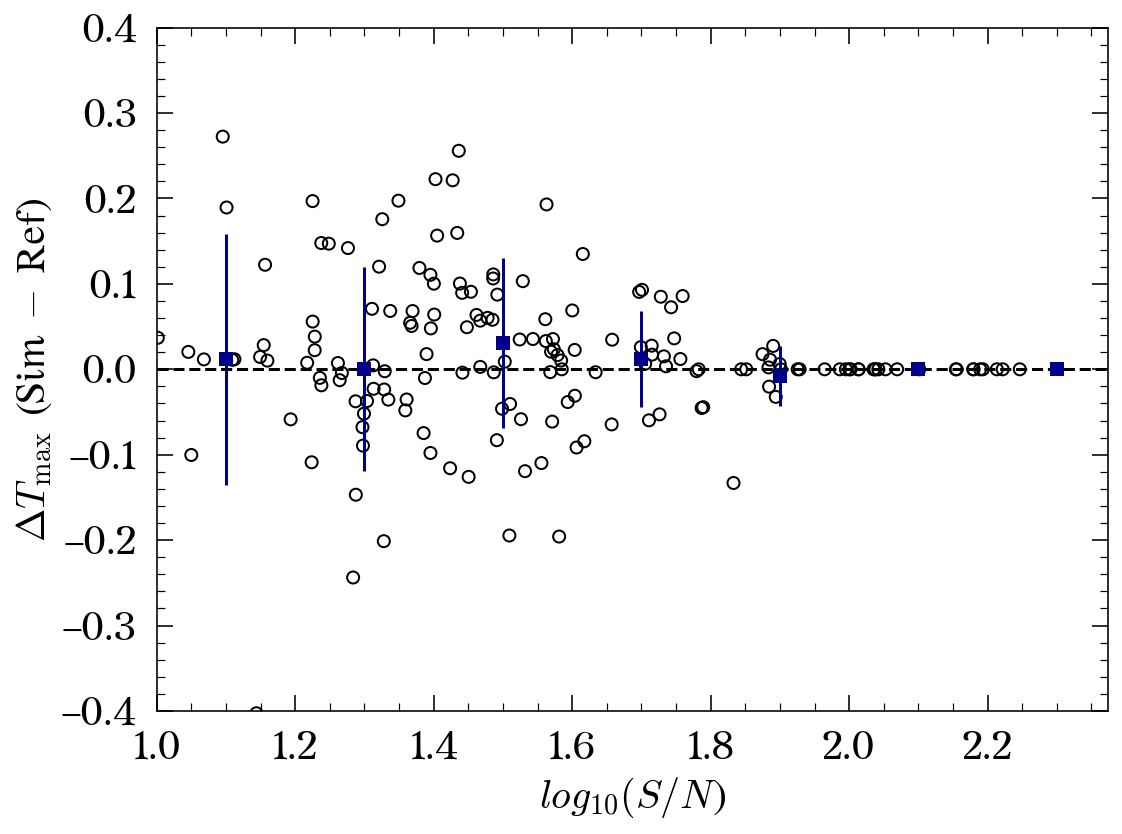

In [50]:
df = res_df[np.abs(res_df.Tmax_diff)<0.85]  # weird outliers

step = 0.2
bins = np.arange(0.8, 2.2+step, step)
bins_results =  bin_values(bins, np.log10(df.g.values), 
                           df.Tmax_diff.values, 
                           np.ones_like(df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(np.log10(df.g), df.Tmax_diff, marker='o' , ec='k', facecolors='none')

# bins
ax.errorbar(bins-step/2, delta_bins, yerr=std_bins, fmt='s', c='darkblue')

ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$log_{10}(S/N$)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(1, None)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_snr.pdf')
plt.show()

___

## S/N on NIR

Get the closest NIR epoch to Tmax and degrade the S/N to see how that affects Jmax. Use grJ with all data and grJ with one J epoch as a references.

In [72]:
bands = None
multi = range(2, 11)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

snr_list = Pool(PROCESSES).map(pool_fit_NIR_snr, ([sn_file, multi, bands] for sn_file in sn_files))

/tmp/ipykernel_6431/2895874389.py:122: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_6431/2895874389.py:122: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_6431/2895874389.py:122: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 6 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 4 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 7 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for SN2007bd: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_6431/2895874389.py:122: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 7 failed for SN2011iv: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_6431/2895874389.py:122: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


In [73]:
nir_snr_stats_df = pd.concat(snr_list, ignore_index=True)
nir_snr_stats_df.to_csv('nir_snr_stats.csv', index=False)

___
### S/N on NIR Analysis

In [239]:
nir_snr_stats_df = pd.read_csv('nir_snr_stats.csv')
ab_df = pd.read_csv('reference_results_max_model.csv')  # AllBands (ab)
ab_df.Jmax_AllBands.values

sn_names = nir_snr_stats_df.name.unique()
snr_threshold = 21

res_dict = {'Jmax_diff0':[], 'Jmax_err':[], 
            'Jmax_diff1':[],
            'Hmax_diff0':[], 'Hmax_err':[], 
            'Hmax_diff1':[],
            'J':[], 'H':[]}

ref_mean_J_cad = []
ref_mean_H_cad = []
for sn_name in sn_names:
    sn_df = nir_snr_stats_df[nir_snr_stats_df.name==sn_name]
    ref_df0 = sn_df.iloc[0]
    ref_df1 = sn_df.iloc[1]
    ref_mean_J_cad.append(ref_df0.J)
    ref_mean_H_cad.append(ref_df0.H)
    sn_ab_df = ab_df[ab_df.name==sn_name]
        
    sim_df = sn_df[2:]  # remove reference from this df
    sim_df = sn_df[sn_df.J>=snr_threshold]
    #Jmax_diff0 = sim_df.Jmax.values - ref_df0.Jmax
    Jmax_diff0 = sim_df.Jmax.values - sn_ab_df.Jmax_AllBands.values[0]
    Jmax_diff1 = sim_df.Jmax.values - ref_df1.Jmax
    #Hmax_diff0 = sim_df.Hmax.values - ref_df0.Hmax
    Hmax_diff0 = sim_df.Hmax.values - sn_ab_df.Hmax_AllBands.values[0]
    Hmax_diff1 = sim_df.Hmax.values - ref_df1.Hmax
    res_dict['Jmax_diff0'] += list(Jmax_diff0)
    res_dict['Jmax_diff1'] += list(Jmax_diff1)
    res_dict['Jmax_err'] += list(sim_df.Jmax_err)
    res_dict['Hmax_diff0'] += list(Hmax_diff0)
    res_dict['Hmax_diff1'] += list(Hmax_diff1)
    res_dict['Hmax_err'] += list(sim_df.Hmax_err)
    res_dict['J'] += list(sim_df.J)
    res_dict['H'] += list(sim_df.H)
            
res_df = pd.DataFrame(res_dict)
# weird outliers, but just very few simulations
# res_df = res_df[res_df.Tmax_diff>-2]  # huge Tmax diff
# res_df = res_df[res_df.Tmax_err>0.001]  # I don't trust these small uncertainties 
ref_mean_J_cad = np.array(ref_mean_J_cad)
ref_mean_H_cad = np.array(ref_mean_H_cad)
print(ref_mean_J_cad.mean(), ref_mean_H_cad.mean())

54.17344635426565 38.65800216280707


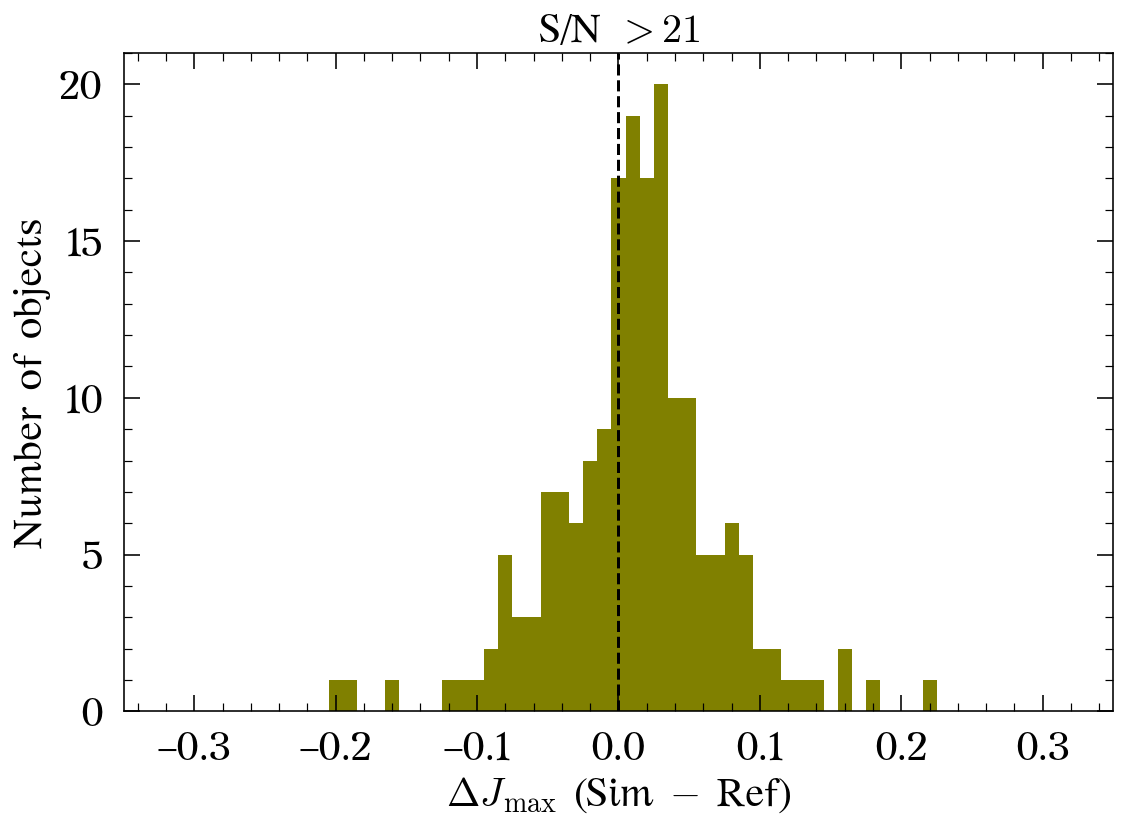

0.013305336527585903 0.05963699137931509
0.0004017888407407801 0.04504803610592518


In [240]:
band = 'J'
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.505, 0.5, 0.01)
ax.hist(res_df.Jmax_diff0, bins, color='olive', label=f'Ref: all ${band}$-band data')
#ax.hist(res_df.Jmax_diff1, bins, color='darkcyan', alpha=0.4, 
#                            label=f'Ref: one ${band}$-band epoch\n\t around '+'$T_{max}$')
ax.axvline(0, ls='--', c='k')
wmean0 = np.average(res_df[f'{band}max_diff0'], 
                    weights=1/res_df[f'{band}max_err']**2)
wmean1 = np.average(res_df[f'{band}max_diff1'], 
                    weights=1/res_df[f'{band}max_err']**2)
#ax.axvline(wmean0, ls='dotted', c='olive')
#ax.axvline(wmean1, ls='dotted', c='darkcyan')

ax.set_xlabel(f'$\Delta {band}$'+r'$_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.set_title(f'S/N $> {snr_threshold}$', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.35, 0.35)
#ax.legend(fontsize=14)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_{band}max_nir_snr.pdf')
plt.show()

print(wmean0, res_df[f'{band}max_diff0'].std())
print(wmean1, res_df[f'{band}max_diff1'].std())

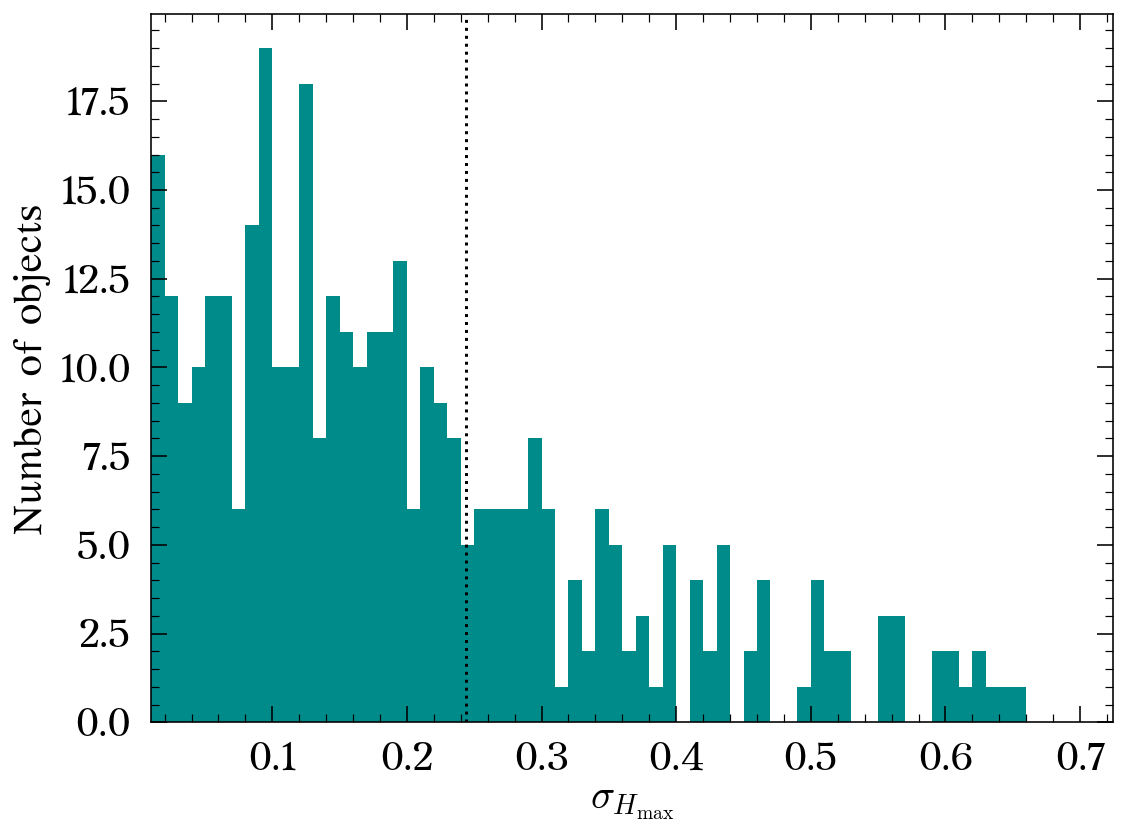

0.24399840830926395


In [234]:
fig, ax = plt.subplots(figsize=(8, 6))

if band=='H':
    bins = np.arange(0, 0.7, 0.01)
else:
    bins = np.arange(0, 0.5, 0.01)
ax.hist(res_df[f'{band}max_err'], bins, color='darkcyan')
ax.axvline(res_df[f'{band}max_err'].mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{%s_{\rm max}}$'%band, fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.01, None)

fig.tight_layout()
plt.savefig(f'paper_plots/sigma_{band}max_nir_snr.pdf')
plt.show()
print(res_df[f'{band}max_err'].mean())

In [252]:
df = pd.read_csv('/home/tomas/Downloads/2021fof-ztf.csv', skiprows=14)
print('filt \t S/N \t obs. cadence')
for filt in df.photfilter.unique():
    filt_df = df[df.photfilter==filt]
    mag = 18.15
    mag_err = 0.052
    zp = 27.5
    flux = 10**( -0.4*(filt_df.mag.values-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*filt_df.mag_err.values )
    snr = np.mean(flux/flux_err)
    print(filt, snr, np.mean(np.diff(filt_df.time)))

filt 	 S/N 	 obs. cadence
gp 11.940489006445976 3.5516689799912275
rp 14.083415141546096 3.142737911100051


In [241]:
# pick high-z SNe
z_list = []
for sn_file in glob.glob('csp_data/*'):
     with open(sn_file, 'r') as data_file:
            sn_info = data_file.readline().split()  # header
            z = float(sn_info[1])
            z_list.append(z)
            
z_array = np.array(z_list)

mask = z_array > 0.08
highz_sne = np.array(glob.glob('csp_data/*'))[mask]

#---------------
zp_dict = {'J':13.836, 'H':13.510}
zp = zp_dict[band]
names = ['mjd', 'mag', 'mag_err']

print('SN \t z \t S/N')
avg_snr = []
for k, sn_file in enumerate(highz_sne):
    skiprows = None
    nrows = None
    with open(sn_file, 'r') as data_file:
        for i, line in enumerate(data_file.readlines()):
            if band in line:
                skiprows = i
            if skiprows is not None:
                if 'filter' in line.split() and band not in line:
                    nrows = i - skiprows
                    break
       
    if nrows is None:
        nrows = 100
        
    if skiprows is None:
        continue
    
    sn_df = pd.read_csv(sn_file, names=names, skiprows=skiprows+1, 
                        nrows=nrows-1, delim_whitespace=True)
    
    flux = 10**( -0.4*(sn_df.mag.values-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*sn_df.mag_err.values )
    snr = flux/flux_err
    print(sn_file, z_array[mask][k], snr)
    avg_snr.append(snr.mean())
    
avg_snr = np.array(avg_snr)
print(avg_snr.mean())

SN 	 z 	 S/N
csp_data/LSQ13pf_snpy.txt 0.086 [11.42880216]
csp_data/LSQ12bld_snpy.txt 0.0834 [36.19120683 20.10622601 16.20501798]
csp_data/CSP13aad_snpy.txt 0.0868 [ 7.98335445 11.67458285 10.6444726 ]
csp_data/LSQ14age_snpy.txt 0.0805 [16.9646282  16.20501798]
csp_data/LSQ14gfn_snpy.txt 0.1216 [11.67458285]
csp_data/LSQ14gov_snpy.txt 0.0895 [29.34422175 21.7147241 ]
csp_data/LSQ12aor_snpy.txt 0.0933 [16.9646282  18.71958974 10.05311301]
csp_data/LSQ12gln_snpy.txt 0.102 [32.90109711 24.67582284 17.23390801 18.71958974 14.8730987 ]
csp_data/CSP12N_snpy.txt 0.0971 [29.34422175 15.96670889 13.08115909]
csp_data/LSQ14bjj_snpy.txt 0.0811 [38.77629303 40.21245203 26.48137085 27.14340512]
csp_data/LSQ12cdl_snpy.txt 0.1079 [14.28600269 12.1992832  15.51051721 12.47972649]
csp_data/LSQ13dcy_snpy.txt 0.0801 [41.7590848  35.02374854]
csp_data/LSQ14auy_snpy.txt 0.0824 [45.23900853 31.02103442 36.19120683]
21.4249159493193


--------------------------------------------------------------------------------
SN  SN2005M
z = 0.0220          zcmb = 0.0230          ra=144.38480         dec= 23.20070 
Data in the following bands: g,  u,  V,  r,  i,  B,  J,  H,  K,  Y,  
Fit results (if any):
   st = 1.209  +/-  0.002  +/- 0.030 (sys)
   Tmax = 53405.745  +/-  0.019  +/- 0.340 (sys)
   gmax = 15.860  +/-  0.002  +/- 0.014 (sys)
   umax = 16.225  +/-  0.004  +/- 0.030 (sys)
   Vmax = 15.908  +/-  0.002  +/- 0.019 (sys)
   rmax = 16.005  +/-  0.002  +/- 0.022 (sys)
   imax = 16.530  +/-  0.003  +/- 0.022 (sys)
   Bmax = 15.939  +/-  0.002  +/- 0.012 (sys)
   Jmax = 16.682  +/-  0.140  +/- 0.044 (sys)
   Hmax = 16.684  +/-  0.016  +/- 0.055 (sys)
   Kmax = 16.551  +/-  0.046
   Ymax = 16.669  +/-  0.014  +/- 0.050 (sys)
None


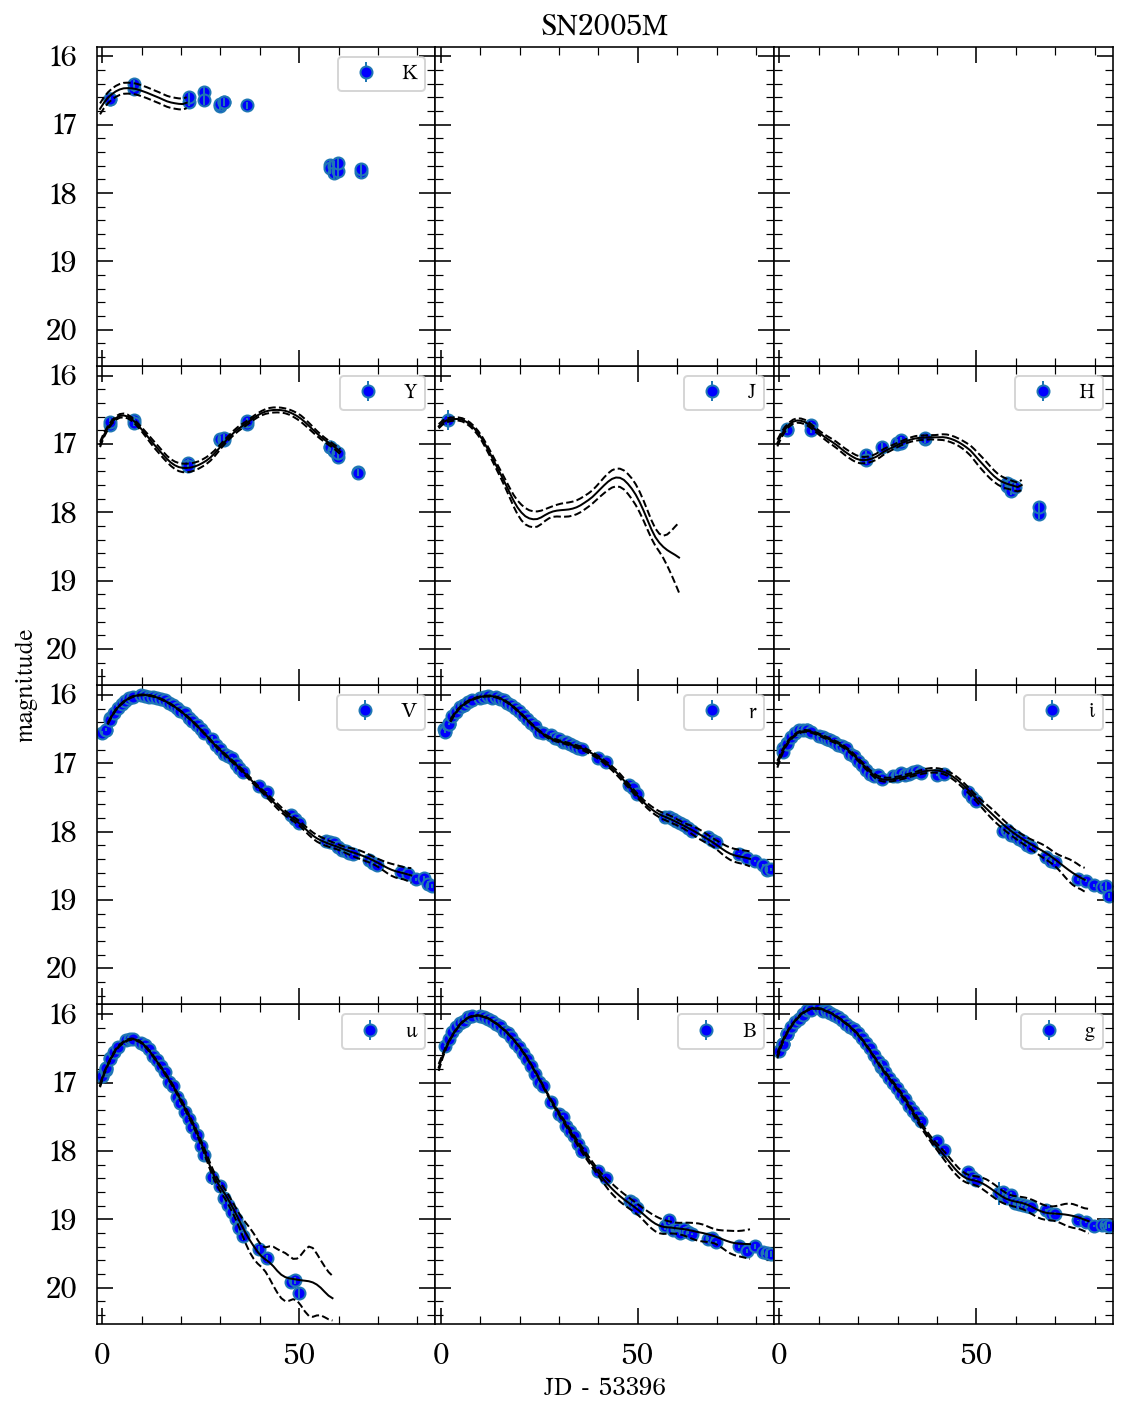

In [68]:
sn = snpy.import_lc('csp_data/SN2005M_snpy.txt')
sn.choose_model(SNOOPY_MODEL)

mult = 3
band = 'J'
sn.data[band].e_flux = mult*sn.data[band].e_flux
sn.data[band]._eflux = mult*sn.data[band]._eflux

zp = sn.data[band].mag + 2.5*np.log10(sn.data[band].flux)
# randomise observations within uncertainties
new_flux = np.random.normal(sn.data[band].flux, 
                            sn.data[band].e_flux)
sn.data[band].flux = new_flux

# update magnitudes and mag errors
new_mag = -2.5*np.log10(new_flux) + zp
new_mag_err = np.abs( 2.5*sn.data[band].e_flux/(new_flux*np.log(10)) )
sn.data[band].mag = new_mag
sn.data[band].magnitude = new_mag
sn.data[band].e_mag = new_mag_err

sn.fit()
print(sn.summary())